# **Préparation du dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [3]:
# Vérification de la disponibilité de CUDA
print("CUDA disponible :", tf.test.is_built_with_cuda())

# Vérification de la compatibilité CUDA
print("Compatibilité CUDA :", tf.test.is_gpu_available(cuda_only=False))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


CUDA disponible : True
Compatibilité CUDA : True


In [2]:
from sklearn import preprocessing
from google.colab import drive

# Chemin du répertoire des images
path = '/content/drive/My Drive/Flipkart/Images'
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
list_photos = [file for file in listdir(path)]
print(len(list_photos))
print(list_photos)

1050
['3ccceaae844f34180708cb6cba3441bf.jpg', 'e921fc17a0ed9a58f76d38558deb9337.jpg', 'b6c339777814451815fe7950fd4c8536.jpg', 'ee78c1e94bdc217d1d0eaef5c567417a.jpg', '26269fd0df12630eec4508c2cf3c94e1.jpg', 'b90046b67cafcedfd363afba5fafc1c7.jpg', 'f8aa59c4a170e8a90ae832b173b2b2d9.jpg', 'c6f4475e2385cc16ce83f21f975614b3.jpg', 'cc24426f00c1cf9ae0bf76e8bd23c336.jpg', '2231a6fc63274c46043e353f1728f077.jpg', 'd8ef80a8ba345dedc9f944cf21201988.jpg', 'd7fded8e211b3033e424fb450b97caec.jpg', '8e961e4fd248c9496ca54808d2d2b25f.jpg', '750f964cf8e6a16412aaf2b0d0350d0a.jpg', '49f7763dc9c7ece284a1ae27166f8c6c.jpg', '95feec21a9d076cff084159d61bf9b8e.jpg', 'f0d5e49c1a5aead18d5ff2e8f611de4e.jpg', '0b8c4bc35aee94af356cb1fd2dfa0219.jpg', 'e6b483fce5fd910afda67d97dc04e775.jpg', '7cb1ea7b2257aeeeba701a8f6e3e0127.jpg', '3b0f02b3acf1825f8bbc1fb3b860dbb8.jpg', '8ec6ee9814a27423e66c3c9ea26f77aa.jpg', '050ea3acb555bf641e7ae9b4f3ba684a.jpg', '650e27dff8f645649353743f64e03f77.jpg', '4e09d5a71d46d61de3d4c9c5aedb73f2.

In [4]:
data_cat_num = pd.read_csv('/content/drive/My Drive/Flipkart/data_cat_num.csv')
data_cat_num.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,label,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",4,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",0,Baby Care


In [5]:
from sklearn import preprocessing

data_photos = pd.DataFrame()
data_photos[['Image', 'Label_name', 'Label']] = data_cat_num[['image', 'product_category', 'label']]
data_photos

,Image,Label_name,Label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [6]:
data_grp= data_photos.groupby(["Label_name","Label"]).count()
data_grp

,,Image
Label_name,Label,
Baby Care,0,150
Beauty and Personal Care,1,150
Computers,2,150
Home Decor & Festive Needs,3,150
Home Furnishing,4,150
Kitchen & Dining,5,150
Watches,6,150


In [7]:
data_photos.to_csv('/content/drive/My Drive/Flipkart/data_photos.csv', index=False)

In [8]:
list_labels = data_photos['Label_name'].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [9]:
list_labels_num = data_photos['Label'].unique().tolist()
list_labels_num

[4, 0, 6, 3, 5, 1, 2]

In [10]:
for i, label in zip(list_labels_num, list_labels):
    globals()["data_photos_train_" + str(i)] = data_photos.loc[data_photos['Label_name'] == label][:100]
    globals()["data_photos_test_" + str(i)] = data_photos.loc[data_photos['Label_name'] == label][100:150]
data_photos_test_1

,Image,Label_name,Label
686,911a6efe69bde398fbbddcb0b4bb466f.jpg,Beauty and Personal Care,1
687,d61b368146f83075937e144dab93c6a1.jpg,Beauty and Personal Care,1
688,bc2aaae47829fd5825f6cc2ec51c2c5f.jpg,Beauty and Personal Care,1
690,cdc33ed715261b08e315a2a19427bc23.jpg,Beauty and Personal Care,1
691,c65fa0b38ab99792630468bd7dd26416.jpg,Beauty and Personal Care,1
692,142994b421c052a6193052c6c8c3d076.jpg,Beauty and Personal Care,1
730,cabeeb2c7f68a833964bf7329d360886.jpg,Beauty and Personal Care,1
735,aa82b75da7579007963e53b6f818281b.jpg,Beauty and Personal Care,1
736,e33795f66b2a42ac56095ae704ab25b6.jpg,Beauty and Personal Care,1
737,1dbe1f3ba28460dffef4a1d664549621.jpg,Beauty and Personal Care,1


In [11]:
data_photos_test = pd.concat([data_photos_test_0, data_photos_test_1, data_photos_test_2, data_photos_test_3, data_photos_test_4, data_photos_test_5, data_photos_test_6])
data_photos_test

,Image,Label_name,Label
774,093bcad64d11c0aed903a8dd787ef069.jpg,Baby Care,0
775,93618b8a998782d4d847ee5cba5c7de2.jpg,Baby Care,0
776,c1e9b5875e442203073211c522072973.jpg,Baby Care,0
783,9a0413117aa91c668ba5944770347cc5.jpg,Baby Care,0
784,fb435889d257c924c7bf77396a555e04.jpg,Baby Care,0
...,...,...,...
796,170fdf050c7a1f8d30ef5a98c4216f9c.jpg,Watches,6
823,697ad1d2e45c1af54cab7847cbe324d8.jpg,Watches,6
825,3a7b224bf1bc9cee9052f9c9df0355f6.jpg,Watches,6
826,700dfd088162ea00deda33123cd7f2da.jpg,Watches,6


In [12]:
data_photos_train = pd.concat([data_photos_train_0, data_photos_train_1, data_photos_train_2, data_photos_train_3, data_photos_train_4, data_photos_train_5, data_photos_train_6])
data_photos_train

,Image,Label_name,Label
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
40,90e56526f4c5892beac49f262b85150a.jpg,Baby Care,0
42,5325213d84c80ad310b6e4b37a1ac824.jpg,Baby Care,0
63,f4e7f269319ba9cf5507a9e2febacbf5.jpg,Baby Care,0
...,...,...,...
559,8c81ed9792bee1c2d6c3b8289d80eece.jpg,Watches,6
560,c205b200b10aab43be31df8fc1db6d86.jpg,Watches,6
561,49658948b5f4eb06a3ddc2fa75eb41d0.jpg,Watches,6
562,3693c4e7f7efb47edb3d9eec067ffd93.jpg,Watches,6


In [13]:
import os
import shutil

# Chemin du répertoire data_train
data_train_path = '/content/drive/My Drive/Flipkart/data_train'
data_test_path = '/content/drive/My Drive/Flipkart/data_test'

# Création du répertoire data_train et son répertoire parent si nécessaire
os.makedirs(data_train_path, exist_ok=True)
os.makedirs(data_test_path, exist_ok=True)

# Boucle pour créer les sous-répertoires train_category
for label_num, label_name in zip(list_labels_num, list_labels):
    # Nom du sous-répertoire
    subdirectory_name_train = 'train_' + str(label_num)
    subdirectory_name_test = 'test_' + str(label_num)

    # Chemin des sous-répertoires train_category
    subdirectory_path_train = os.path.join(data_train_path, subdirectory_name_train)
    subdirectory_path_test = os.path.join(data_test_path, subdirectory_name_test)

    # Création des sous-répertoires train_category s'ils n'existent pas
    os.makedirs(subdirectory_path_train, exist_ok=True)
    os.makedirs(subdirectory_path_test, exist_ok=True)



In [14]:
# Boucle pour copier les images dans les sous-répertoires
for label_num, label_name in zip(list_labels_num, list_labels):
    # Nom du sous-répertoire
    subdirectory_name_train = 'train_' + str(label_num)
    subdirectory_name_test = 'test_' + str(label_num)

    # Chemin des sous-répertoires train_category
    subdirectory_path_train = os.path.join(data_train_path, subdirectory_name_train)
    subdirectory_path_test = os.path.join(data_test_path, subdirectory_name_test)

    # Filtrer les images correspondantes au label pour train et test
    images_train = data_photos_train.loc[data_photos_train['Label'] == label_num, 'Image'].tolist()
    images_test = data_photos_test.loc[data_photos_test['Label'] == label_num, 'Image'].tolist()

    # Copier les images dans les sous-répertoires train
    for image_train in images_train:
        src_train = os.path.join(path, image_train)
        dst_train = os.path.join(subdirectory_path_train, image_train)
        shutil.copy(src_train, dst_train)

    # Copier les images dans les sous-répertoires test
    for image_test in images_test:
        src_test = os.path.join(path, image_test)
        dst_test = os.path.join(subdirectory_path_test, image_test)
        shutil.copy(src_test, dst_test)


In [ ]:
data_photos_train.to_csv('/content/drive/My Drive/Flipkart/data_photos_train.csv', index=False)
data_photos_test.to_csv('/content/drive/My Drive/Flipkart/data_photos_test.csv', index=False)

# Etape 1 : étude de faisabilité


## Création du modèle pré-entraîné

In [ ]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## Création des features des images

In [ ]:
file_photos = path + '/' + data_photos['Image']

In [ ]:
images_features = []
i=0
for image_file in file_photos :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)

images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [ ]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 799)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [ ]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            19.74 secondes


<ipython-input-27-ceff6bcbb784>:5: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


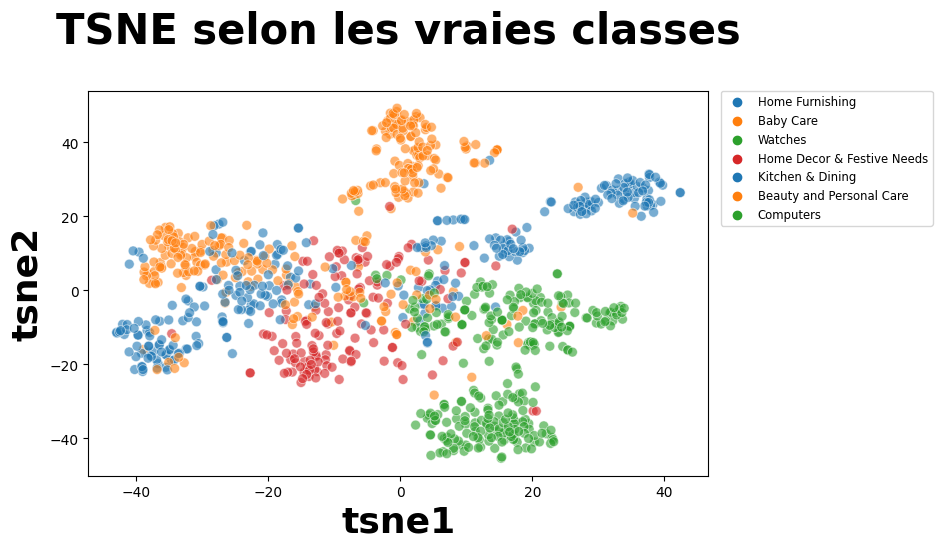

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_photos["Label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})
# Réduire la taille de l'encadré de la légende
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='small')
plt.savefig('/content/drive/My Drive/Flipkart/cm-sift.png')
plt.show()


### Création de clusters à partir du T-SNE et affichage des images selon clusters


In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)


KMeans(n_clusters=7, n_init=100)

<ipython-input-29-72c94f3a5483>:4: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot( x="tsne1", y="tsne2", hue="cluster",


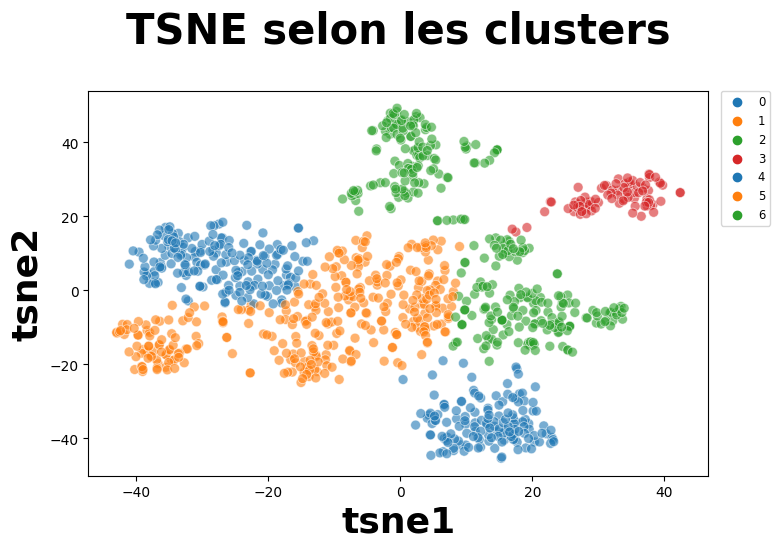

ARI :  0.46664300501496075


In [ ]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot( x="tsne1", y="tsne2", hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})
# Réduire la taille de l'encadré de la légende
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='small')
plt.show()

labels = data_photos["Label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [ ]:
# Analyse d'image "Baby Care" affectées au cluster 4 "Home Furnishing"

list_baby_0= [i for i in range(len(data_photos["Image"])) \
                if (data_photos.iloc[i]['Label_name']=='Baby Care') and (df_tsne.iloc[i]['cluster']==4)]
list_baby_0[0]

1

tsne1     -26.537472
tsne2      -3.394317
class      Baby Care
cluster            4
Name: 1, dtype: object


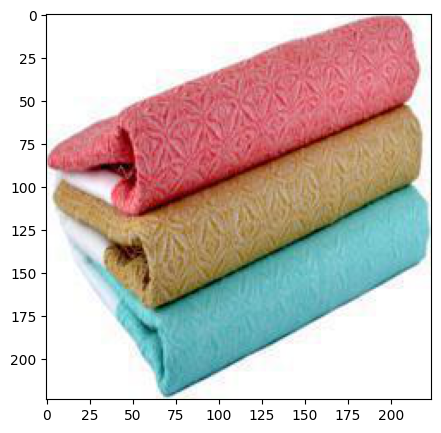

In [ ]:
# Affichage image "Baby Care" considérée comme "Home Furnishing"
id = 1
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = file_photos[id]
image = imread(filename)
plt.imshow(image)
plt.show()


* Analyse : le modèle pré-entraîné confond "Home Decor & Festiv Needs" avec "Baby Care"



### Analyse par classes

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  1  28   2   1 110   7   1]
 [  1  17 118   1   3   3   7]
 [  1  31   1   0   0   0 117]
 [  5  82   1   1   6  49   6]
 [  0   7   0   0  63  80   0]
 [  0  32   9  81   0   0  28]
 [136   2   0   0   0   0  12]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [ ]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6 3 1 5 0 4 2]
[[110   2   1  28   7   1   1]
 [  3 118   7  17   3   1   1]
 [  0   1 117  31   0   0   1]
 [  6   1   6  82  49   1   5]
 [ 63   0   0   7  80   0   0]
 [  0   9  28  32   0  81   0]
 [  0   0  12   2   0   0 136]]

              precision    recall  f1-score   support

           0       0.60      0.73      0.66       150
           1       0.90      0.79      0.84       150
           2       0.68      0.78      0.73       150
           3       0.41      0.55      0.47       150
           4       0.58      0.53      0.55       150
           5       0.96      0.54      0.69       150
           6       0.94      0.91      0.93       150

    accuracy                           0.69      1050
   macro avg       0.73      0.69      0.70      1050
weighted avg       0.73      0.69      0.70      1050



<Axes: >

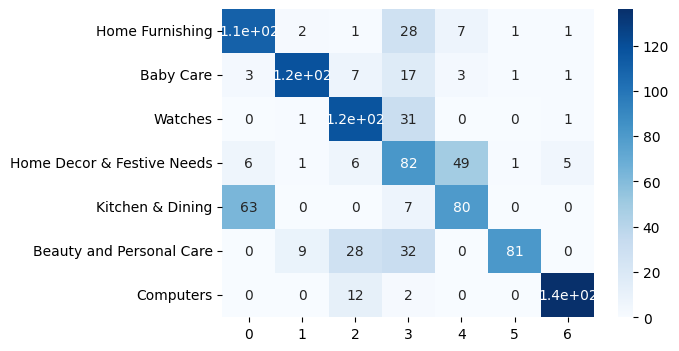

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.savefig('/content/drive/My Drive/Flipkart/cm-VGG16.png')

* La classe la moins bien prédite est "kitchen & Dining"